In [17]:
import pandas as pd 
import numpy as np
from math import sqrt
from copy import deepcopy
import matplotlib.pyplot as plt  
from sklearn.metrics import mean_absolute_error, mean_squared_error
#For e-autoMFIS, we import all of them.
from eautoMFIS_V2 import autoMFIS
from fuzzyfication import Fuzzification
from preprocessing import Preprocess
from utils import *

from pymoo.core.problem import  ElementwiseProblem
from pymoo.core.variable import Real, Integer, Choice
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize
from multiprocessing.pool import ThreadPool
from pymoo.core.problem import StarmapParallelization

from memory_profiler import profile
import gc

import warnings
warnings.filterwarnings("ignore")

%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [2]:
class MemoryCleanup:
    def __enter__(self):
        pass
    
    def __exit__(self, exc_type, exc_value, traceback):
        gc.collect()
        pass

# Pre-Processamento

In [3]:
data = pd.read_csv('AirQualityUCI.csv',sep=';',decimal='.')

data.dropna(thresh=1, inplace=True)
data.drop(labels=['Unnamed: 15', 'Unnamed: 16'],axis=1,inplace=True)

data.fillna(method='bfill',inplace=True)

def convert_object_to_float(data,datanames):
    for name in datanames:
        dname = data[name].values.astype('str')
        dname = [new_value.replace(',','.') for new_value in dname]
        data[name] = dname
        data[name] = data[name].astype(float)
    return data

inames = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']

data = convert_object_to_float(data,inames)

data = data.select_dtypes(include=['float'])
   
data = data.where(data != -200)
data.isnull().sum()



CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [4]:
# Preenchimento de dados faltantes
data.fillna(method='bfill',inplace=True)

data.isnull().sum()

CO(GT)              0
PT08.S1(CO)         0
NMHC(GT)         8126
C6H6(GT)            0
PT08.S2(NMHC)       0
NOx(GT)             0
PT08.S3(NOx)        0
NO2(GT)             0
PT08.S4(NO2)        0
PT08.S5(O3)         0
T                   0
RH                  0
AH                  0
dtype: int64

In [5]:
# Excluindo variáveis não utilizadas
data.drop(labels=['NMHC(GT)', 'PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)','PT08.S4(NO2)','PT08.S5(O3)'],axis=1,inplace=True)

In [6]:
data = data[9000:-24]
data = data[['NO2(GT)', 'C6H6(GT)', 'NOx(GT)', 'T', 'CO(GT)']]
dataset = data.values
data

,NO2(GT),C6H6(GT),NOx(GT),T,CO(GT)
9000,128.0,6.6,240.0,19.3,1.7
9001,155.0,12.7,398.0,17.3,2.9
9002,176.0,14.8,585.0,16.0,4.0
9003,179.0,12.3,590.0,15.6,4.0
9004,124.0,6.3,295.0,14.8,1.9
...,...,...,...,...,...
9328,113.0,3.4,166.0,21.1,1.4
9329,115.0,5.3,171.0,24.0,1.3
9330,124.0,5.3,177.0,26.5,1.4
9331,86.0,3.8,119.0,28.7,1.0


In [7]:
lag = 24
h_teste = 24
h_validation = 24
h_train = dataset.shape[0] - h_teste - h_validation

a = dataset.shape[0]
all_data = dataset[lag:,:]
training_data = dataset[lag:lag+h_train,:]
test_data = dataset[a - h_teste:a,:]

In [ ]:
# plt.figure(figsize=(32,50))
# for n in range(dataframe.shape[1]):
#     plt.subplot(4,2,n+1)
#     plt.plot(all_data[:,n])
#     plt.xlabel('Time(h)',fontsize=20)
#     plt.ylabel('Value',fontsize=20)
#     plt.title(dataframe.columns[n],fontsize=30)

In [ ]:
# for n in range(dataframe.shape[1]):
#     print(f'{dataframe.columns[n]}: Max Value: {dataframe[dataframe.columns[n]].max()}')
#     print(f'{dataframe.columns[n]}: Min Value: {dataframe[dataframe.columns[n]].min()}')

In [ ]:
# data_ = training_data

In [8]:
#Basic informations 
n_predictors = 60
num_input = 12
lag_notused = np.array([[4,5],[4,5],[4],[4,5]])
not_used_lag = False

#Actually, lag stands for all inputs for each serie. Example, lag = 2 uses s(t) and s(t-1) to predict s(t+1)
diff_series = False
detrend_series = False

num_series = training_data.shape[1]  #Numero de series do problema, extraído dos dados

# max_rulesize = 5 #Max numbers of premises rules.
# min_activation = 0.58 #Minimum activation

form_method = 'nmean'
split_method = 'FCD'
solve_method = 'mqr'
#####Definicao de funcoes######
#detrend_method = ''
#bin_method = ''

fuzzy_method = 'mfdef_cluster'
# num_groups = 7

defuzz_method = 'height'

ensemble_rules = None

total_number = training_data.shape[1]*lag


filepath = 'results V2'

target_position = 4

In [10]:


#Normalize data 
# scaler = StandardScaler()
#scaler = MinMaxScaler()
# preprocess_data = Preprocess(deepcopy(training_data), lag, h_prev=h_validation,num_series=num_series, target_position = target_position)

#For training set
#training_set_orig, val_set_orig = preprocess_data.diff_series()
# training_set, val_set = preprocess_data.split_data()
# correlation_array = preprocess_data.spearman_corr_weights()
# autocorrelation_matrix = preprocess_data.linear_acf_weights()
#training_set_orig, val_set_orig, trends = preprocess_data.detrend_series()

#diff_data = np.concatenate((training_set_orig, val_set_orig))

#norm_data = scaler.fit_transform(diff_data)
#training_set = scaler.transform(training_set_orig)
#val_set = scaler.transform(val_set_orig)

#training_set[abs(training_set) > 3] = 0
''' 
yp - dados de entrada do modelo com defasagem de 24 passos [t + lag: t + (dataset[0] - lag), numero de variáveis], 
yt - dados de entrada do modelo com defasagem de 25 passos (1 passo a frente de yt) [t + (lag +1), t + (dataset[0] - lag) + 1, numero de variáveis],
yp_lagged - amtriz oformada pela defasagem de todas as variáveis juntas[t + lag: t + (dataset[0] - lag), numero de variáveis*lag]'''
# yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)
#For all set. This will be useful for initial values of prediction
# all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = dataset, lag = lag)

' \nyp - dados de entrada do modelo com defasagem de 24 passos [t + lag: t + (dataset[0] - lag), numero de variáveis], \nyt - dados de entrada do modelo com defasagem de 25 passos (1 passo a frente de yt) [t + (lag +1), t + (dataset[0] - lag) + 1, numero de variáveis],\nyp_lagged - amtriz oformada pela defasagem de todas as variáveis juntas[t + lag: t + (dataset[0] - lag), numero de variáveis*lag]'

In [ ]:
# yt_var_samples, yp_var_samples, yp_lagged_var_samples = preprocess_data.generate_subsamples(correlation_array, 
#                                                                                             autocorrelation_matrix, 
#                                                                                             num_input,
#                                                                                             training_set)

In [ ]:
# columns_to_keep = np.random.choice(training_set.shape[1], np.random.randint(1, training_set.shape[1]+1), p=correlation_array, replace=False)
# yp_var_samples = deepcopy(yp)
# yt_var_samples = deepcopy(yt)
# yp_var_samples[:, [i for i in range(num_series) if i not in columns_to_keep]] = np.nan
# yt_var_samples[:, [i for i in range(num_series) if i not in columns_to_keep]] = np.nan

# yp_lagged_var_samples = deepcopy(yp_lagged)
# # window_var_samples = np.split(np.arange(0, lag*num_series), num_series)
# # for _var in range(num_series):
# #     if _var not in columns_to_keep:
# #         yp_lagged_var_samples[:, window_var_samples[_var]] = np.nan

In [ ]:
###############Fuzzificacao

# Fuzzyfy = Fuzzification(fuzzy_method)

# #Lembrete: 
# #axis 0 - Registros da série
# #axis 1 - Valor de pertinência ao conjunto Fuzzy
# #axis 2 - Numero de séries

# first_time = True
# for n in range(num_series):
#     _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
#     mX, _ = Fuzzyfy.fuzzify(yp_var_samples[:,n],mf_params,num_groups=num_groups)
#     mY, _ = Fuzzyfy.fuzzify(yt_var_samples[:,n],mf_params,num_groups=num_groups)
#     if first_time:
# # Matriz tridimensional (Entradas, nº de partições, nº de variáveis) com as entradas convertidas para valores de pertinência para todas as variáveis
#         mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
# #Semelhante a variável MX_
#         mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
# # Matriz com os valores das partições de cada variável 
#         mf_params_ = np.ndarray([mf_params.shape[0],num_series])
#         first_time = False
# #Mapeamento dos valores
#     mX_[:,:,n] = mX
#     mY_[:,:,n] = mY
#     mf_params_[:,n] = mf_params.ravel()
#     #print(mf_params)
#     #print(mX.shape)


# mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
# for i in range(num_series):
#     mf_params = mf_params_[:,i]
#     for j in range(lag):
#         mX, _ = Fuzzyfy.fuzzify(yp_lagged_var_samples[:,i*lag+j],mf_params,num_groups=num_groups)
#         mX_lagged_[:,:,i*lag+j] = mX
#         #print(i*lag+j)

# ############## Formulacao
# if not_used_lag:
#     new_mX, lags_used = remove_lags(mX_lagged_,lag_notused,num_series,lag)
# else:
#     new_mX = mX_lagged_



In [9]:
def fuzzy_external(fuzzy_method, num_series, training_set, num_groups, yp, yt, yp_lagged, lag):
    ###############Fuzzificacao

    Fuzzyfy = Fuzzification(fuzzy_method)

    #Lembrete: 
    #axis 0 - Registros da série
    #axis 1 - Valor de pertinência ao conjunto Fuzzy
    #axis 2 - Numero de séries

    first_time = True
    # print(f'Serie fuzzification')
    for n in range(num_series):
        _, mf_params = Fuzzyfy.fuzzify(training_set[:,n],np.array([]),num_groups=num_groups)
        mX, _ = Fuzzyfy.fuzzify(yp[:,n],mf_params,num_groups=num_groups)
        mY, _ = Fuzzyfy.fuzzify(yt[:,n],mf_params,num_groups=num_groups)
        if first_time:
            mX_ = np.ndarray([mX.shape[0],mX.shape[1], num_series])
            mY_ = np.ndarray([mY.shape[0],mY.shape[1], num_series])
            mf_params_ = np.ndarray([mf_params.shape[0],num_series])
            first_time = False
        mX_[:,:,n] = mX
        mY_[:,:,n] = mY
        mf_params_[:,n] = mf_params.ravel()
        #print(mf_params)
        #print(mX.shape)

    # print('Creating for lag values')
    mX_lagged_ = np.ndarray([mX_.shape[0],mX_.shape[1],yp_lagged.shape[1]])
    for i in range(num_series):
        # print(f'Serie {i}')
        mf_params = mf_params_[:,i]
        for j in range(lag):
            mX, _ = Fuzzyfy.fuzzify(yp_lagged[:,i*lag+j],mf_params,num_groups=num_groups)
            mX_lagged_[:,:,i*lag+j] = mX
            #print(i*lag+j)


    #mX_lagged_[:,:,not_select_subsample] = 0
 
    #print(mX_lagged_[:,:,not_select_subsample])
    ############## Formulacao
    if not_used_lag:
        new_mX, lags_used = remove_lags (mX_lagged_,lag_notused,num_series,lag)
    else:
        new_mX = mX_lagged_

    return Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_

In [39]:
n_threads = 4
pool = ThreadPool(n_threads)
runner = StarmapParallelization(pool.starmap)

In [122]:
preprocess_data = Preprocess(deepcopy(training_data), lag, h_prev=h_validation,num_series=num_series, target_position = target_position)
training_val_set, test_set = preprocess_data.split_data()
training_set, val_set = preprocess_data.split_data(data=training_val_set)
correlation_array = preprocess_data.spearman_corr_weights(in_sample=training_set)
autocorrelation_matrix = preprocess_data.linear_acf_weights(in_sample=training_set)

yt, yp, yp_lagged = preprocess_data.delay_input(in_sample = training_set, lag = lag)
all_yt, all_yp, all_lagged = preprocess_data.delay_input(in_sample = dataset, lag = lag)

initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)
in_sample = deepcopy(training_set)
out_sample = deepcopy(val_set)

In [40]:
class AirQualityProblem(ElementwiseProblem):

    def __init__(self, **kwargs):
            
            vars = {
                # "lag": Integer(bounds=(16,24)),
                # "n_inputs": Integer(bounds=(10,20)),
                "max_rulesize": Integer(bounds=(5, 7)),
                "min_activation": Real(bounds=(0.5, 0.655)),
                # "form_method": Choice(options=["nmean", "freq", "mean"]),
                # "split_method": Choice(options=["FCD", "voting"]),
                # "solve_method": Choice(options=['mqr', 'None']),
                # "fuzzy_method": Choice(options=['mfdef_cluster', 'mfdef_triangle',  'mfdef_tukkey']),
                "num_groups": Choice(options=[3, 5, 7, 9]),
                # "defuzz_method": Choice(options=["height", "cog", "mom" ])
            }
            super().__init__(vars=vars, n_obj=3, **kwargs)

    # @profile
    def _evaluate(self, x,  out, *args, **kwargs):
        # Define o número máximo de threads a serem usadas pelo Python
        
        print(x)
        # lag = x["lag"]
        # num_input = x["n_inputs"]
        max_rulesize = x["max_rulesize"] #Max numbers of premises rules.
        min_activation = x["min_activation"] #Minimum activation
        # form_method = x["form_method"]
        # split_method = x["split_method"]
        # solve_method = x["solve_method"]
        # fuzzy_method = x["fuzzy_method"]
        num_groups = x["num_groups"]
        # defuzz_method = x["defuzz_method"]

        ensemble_rules = None

        # total_number = data_.shape[1]*lag

        filepath = 'results V2'
        
        target_position = 4

        min_error = 400.0

        bres = min_error

        #Concatenate rules
        for i in range(n_predictors):
            with MemoryCleanup():
                # print(i)
                try:
                    _, _, yp_lagged_ = preprocess_data.generate_subsamples(correlation_array=deepcopy(correlation_array),
                                                                            autocorrelation_matrix=autocorrelation_matrix,
                                                                            num_inputs=num_input, 
                                                                            in_sample=in_sample, 
                                                                            yt = yt, 
                                                                            yp = yp, 
                                                                            yp_lagged = deepcopy(yp_lagged))

                    Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, 
                                                                                num_series, 
                                                                                training_set, 
                                                                                num_groups, 
                                                                                yp, 
                                                                                yt,
                                                                                deepcopy(yp_lagged_), 
                                                                                lag)

                    model = autoMFIS(diff_series=diff_series,
                                    detrend_series=detrend_series, 
                                    fuzzy_method=fuzzy_method,
                                    solve_method=solve_method,
                                    defuzz_method=defuzz_method, 
                                    num_groups = num_groups, 
                                    inputs = num_input, 
                                    h_prev = out_sample.shape[0],
                                    num_series = num_series, 
                                    max_rulesize = max_rulesize,
                                    min_activation = min_activation, 
                                    lag = lag, 
                                    target_position = 4, 
                                    hide_values = False, 
                                    form_method = form_method, 
                                    split_method = split_method, 
                                    show=True)

                    model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, deepcopy(mX_lagged_))

                    t_mX_lagged, complete_rules, prem_terms, rules, agg_training, wd_ = model.train(data = dataset, 
                                                                                                    correlation_array = correlation_array, 
                                                                                                    autocorrelation_matrix = autocorrelation_matrix,
                                                                                                    in_sample=in_sample, 
                                                                                                    out_sample=out_sample, 
                                                                                                    lag_notused=[],
                                                                                                    debug=False)


                    predicted_values = np.zeros(test_set.shape)

                    yt_totest, errors = model.predict(
                                                        initial_values, 
                                                        data=dataset, 
                                                        in_sample = yt, 
                                                        out_sample=val_set,
                                                        agg_training=agg_training,
                                                        h_prev=h_teste,
                                                        n_attempt=f'p_subsample_{i}',
                                                        wd_=wd_,
                                                        ensemble_antecedents=rules,
                                                        ensemble_rules=complete_rules,
                                                        filepath=filepath,
                                                        lim=min_error, 
                                                        fig_axis=[4,2],
                                                        ndata=data.columns,
                                                        show=False,
                                                        plot_image = True
                                                     )

                    real_yt = deepcopy(yt_totest)

                    # print(errors)
                    res = errors[1,4]
                    # print(res)
                    if res < bres:
                        bres = res
                        if ensemble_rules is None:
                            ensemble_rules = complete_rules
                            ensemble_prem_terms = prem_terms
                            ensemble_antecedents = rules
                            # print(ensemble_rules.shape)
                        else:
                            ensemble_rules = np.concatenate((ensemble_rules, complete_rules))

                            ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                            ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                            # print(ensemble_rules.shape)
                            #print(ensemble_prem_terms.shape)
                        #print(ensemble_rules[:,0])
                    elif ensemble_rules is None and i == n_predictors - 1:
                        ensemble_rules = complete_rules
                        ensemble_prem_terms = prem_terms
                        ensemble_antecedents = rules
                        # print('No rules match criteria. Using rules to fill the gap')

                except Exception as e:
                    print(e)
                    if 'shapes' in str(e) and i != n_predictors - 1:
                        del  yp_lagged_, Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_, model 
                    if 'values to unpack' in str(e) and i != n_predictors - 1:
                        del  yp_lagged_, Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_
                    if 'memory' in str(e) and i != n_predictors - 1:
                        del  yp_lagged_, Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_, t_mX_lagged, complete_rules, prem_terms, rules, agg_training, wd_
                    pass
                finally:
                    gc.collect()
                
        
        cnt = 0
        list_remove = []

        dict_val = {}

        for i in range(ensemble_prem_terms.shape[0]):
            except_one = np.copy(ensemble_prem_terms)
            v = except_one[i,:]
            idx = np.argwhere(v > 0.5).ravel()
            v = v[idx]
            rest = np.delete(except_one, i, axis=0)
            rest = rest[:,idx]
            cpare = np.tile(v,(rest.shape[0],1))
            m = np.minimum(rest,cpare) 
            M = np.maximum(rest,cpare) + 10e-15
            res = m/M
            mean = np.mean(res,axis=1)
            #plt.figure()
            #plt.hist(mean)
            
            vv = np.argwhere(mean > 0.6).ravel()

            if vv.shape[0] > 0:    
                vv[vv > i] += 1
                vv2 = np.append(vv,np.array([i]))

                eval_v = ensemble_prem_terms[vv2][:,idx]

                t = np.mean(eval_v,axis=1)

                keep_val = vv2[np.argmax(t)]
                vmax = np.max(t)
                if keep_val not in list_remove:
                    dict_val[keep_val] = 1
                    list_remove.append(keep_val)
                else:
                    dict_val[keep_val] = dict_val[keep_val] + 1

                cnt += np.argwhere(mean > 0.6).shape[0]

        filtered_rules = deepcopy(ensemble_rules[list_remove,:])
        filtered_prems = deepcopy(ensemble_prem_terms[list_remove,:])
        filtered_antecedents = deepcopy(ensemble_antecedents[list_remove,:])
        
        # print(f'filtered_rules: {sys.getsizeof(filtered_rules)}')
        # print(f'filtered_prems: {sys.getsizeof(filtered_prems)}')
        # print(f'filtered_antecedents: {sys.getsizeof(filtered_antecedents)}')

        model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
        filtered_wd_, filtered_agg_training = model.reweight_mf(mY_,filtered_rules,filtered_prems)
        # print(f'filtered_wd_: {sys.getsizeof(filtered_wd_)}')
        # print(f'filtered_agg_training: {sys.getsizeof(filtered_agg_training)}')

        
        try:
            _, filtered_errors = model.predict(initial_values, 
                                               data=dataset,
                                               out_sample=test_set, 
                                               agg_training=filtered_agg_training,
                                               h_prev=h_teste,
                                               n_attempt='filtered_model',
                                               wd_=filtered_wd_,
                                               ensemble_antecedents=filtered_antecedents,
                                               ensemble_rules=filtered_rules, 
                                               filepath=filepath, lim=min_error,
                                               fig_axis=[4,2],
                                               ndata=data.columns,
                                               show=False,
                                               plot_image = True) 
            
            print(filtered_errors)
            out["F"] = [filtered_errors[1, target_position], filtered_rules.shape[0], filtered_rules.shape[1]]
            print(out)
            # print(f'out: {sys.getsizeof(out)}')

            del training_val_set, training_set, val_set, test_set, correlation_array, autocorrelation_matrix, yt, yp, yp_lagged, all_yt, all_yp, all_lagged 
            del min_error, initial_values, in_sample, out_sample, yp_lagged_, Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_, model, t_mX_lagged, complete_rules
            del prem_terms, rules, agg_training, wd_, predicted_values, yt_totest, errors, cnt, list_remove, dict_val,filtered_rules, filtered_prems 
            del filtered_antecedents, filtered_wd_, filtered_agg_training, filtered_errors
            gc.collect()
            
        except Exception as e:
            print(e)
            out["F"] = [np.inf, np.inf, np.inf]
            del training_val_set, training_set, val_set, test_set, correlation_array, autocorrelation_matrix, yt, yp, yp_lagged, all_yt, all_yp, all_lagged 
            del min_error, initial_values, in_sample, out_sample, yp_lagged_, Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_, model, t_mX_lagged, complete_rules
            del prem_terms, rules, agg_training, wd_, predicted_values, yt_totest, errors, cnt, list_remove, dict_val,filtered_rules, filtered_prems 
            del filtered_antecedents, filtered_wd_, filtered_agg_training
            gc.collect()
            pass
        


In [41]:
algorithm = NSGA2(pop_size=10,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),
                  )

problem = AirQualityProblem(elementwise_runner=runner)

res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               save_history=True,
               verbose=False)


{'max_rulesize': 6, 'min_activation': 0.6038106357045394, 'num_groups': 5}{'max_rulesize': 5, 'min_activation': 0.645008555974935, 'num_groups': 9}

{'max_rulesize': 5, 'min_activation': 0.6311781920863326, 'num_groups': 7}
{'max_rulesize': 6, 'min_activation': 0.5485573951245026, 'num_groups': 3}
shapes (0,) and (212,7) not aligned: 0 (dim 0) != 212 (dim 0)
not enough values to unpack (expected 3, got 2)
[[ 67.56159011   5.00869259 196.36932139   4.01676507   0.50101856]
 [ 59.33812022   4.53523036 145.89711764   3.49558965   0.44447124]
 [  0.65875033   1.91032443   1.2817156    0.24682093   0.57837285]]
{'F': [0.4444712421881866, 18, 5]}
{'max_rulesize': 6, 'min_activation': 0.5813049647337951, 'num_groups': 7}
[[3.79550203e+01 1.33500710e+01 2.48312118e+02 3.06931927e+00
  2.11368638e+00]
 [3.04370589e+01 1.00683401e+01 1.76739627e+02 2.69127633e+00
  1.32603351e+00]
 [3.45833800e-01 4.16511768e+00 1.32860900e+00 2.03076046e-01
  1.48428795e+00]]
{'F': [1.3260335139030415, 31, 5]}


In [97]:

# Flatten the 3-dimensional list into a 2-dimensional array
two_dim_array = [item for sublist in [arr[:, :-1] for arr in [e.opt.get("F") for e in res.history]] for item in sublist]

two_dim_array = np.array(two_dim_array)
np.shape(two_dim_array)


(59, 2)

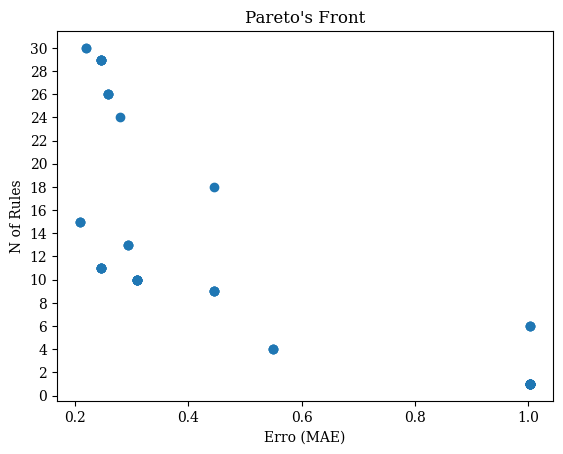

In [114]:
plt.scatter(two_dim_array[:, 0],two_dim_array[:, 1])

plt.xlabel('Erro (MAE)')
plt.ylabel('N of Rules')
plt.xticks(np.arange(0.2, 1.1, 0.2))
plt.yticks(np.arange(0, two_dim_array[:, 1].max() + 1, 2))
plt.title("Pareto's Front")
plt.show()

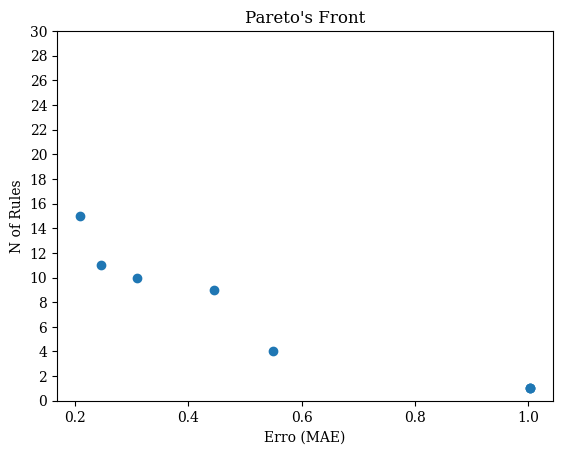

In [117]:
plt.scatter(res.F[:, 0],res.F[:, 1])

plt.xlabel('Erro (MAE)')
plt.ylabel('N of Rules')
plt.xticks(np.arange(0.2, 1.1, 0.2))
plt.yticks(np.arange(0, two_dim_array[:, 1].max() + 1, 2))
plt.title("Pareto's Front")
plt.show()

In [115]:
res.F

array([[ 0.30884897, 10.        ,  5.        ],
       [ 1.00416667,  1.        ,  5.        ],
       [ 0.24562235, 11.        ,  5.        ],
       [ 1.00416667,  1.        ,  5.        ],
       [ 0.4455735 ,  9.        ,  5.        ],
       [ 0.54915294,  4.        ,  5.        ],
       [ 0.20771908, 15.        ,  5.        ],
       [ 1.00416667,  1.        ,  5.        ]])

In [120]:
res.X

array([{'max_rulesize': 5, 'min_activation': 0.6484837576533918, 'num_groups': 3},
       {'max_rulesize': 5, 'min_activation': 0.6491085486517677, 'num_groups': 9},
       {'max_rulesize': 5, 'min_activation': 0.5758693337154359, 'num_groups': 3},
       {'max_rulesize': 5, 'min_activation': 0.6480560022680832, 'num_groups': 9},
       {'max_rulesize': 5, 'min_activation': 0.6446994423080217, 'num_groups': 7},
       {'max_rulesize': 5, 'min_activation': 0.6544650711115743, 'num_groups': 7},
       {'max_rulesize': 5, 'min_activation': 0.645460175743631, 'num_groups': 3},
       {'max_rulesize': 6, 'min_activation': 0.6468559759036904, 'num_groups': 9}],
      dtype=object)

In [119]:
res.X[-2]['max_rulesize']

5

In [131]:
'''
min_error - variável a ser subsituída pelos melhores resultads obtidos  na etapa de validação
bres - melhor resultado obtido ao final da execução de todos o comitê de previsores
initial_values - Não entendi pq pega a esta linha em específico para o predict(?)
in_sample - dados de treinamento
out_sample - dados de teste (a confirmr)
num_predictors - total de previsores (regras formadas) no ensemble
'''
max_rulesize = 5
min_activation = 0.645460175743631
num_groups = 3
min_error = 400.0

bres = min_error

# initial_values = all_lagged[yp_lagged.shape[0],:].reshape(1,-1)
# in_sample = deepcopy(training_set)
# out_sample = deepcopy(val_set)


# print('='*89)

# print(f'Shape of in-sample is {in_sample.shape[0]}')
# #assert in_sample.shape[0] == h_train//7
# print(f'Shape of lagged data is {yp_lagged.shape[0]}')
# #assert yp_lagged1.shape[0] == h_train//manual_pattern
# print(f'Shape of validation set is {out_sample.shape[0]}')

# print('='*89)

#num_predictors = 1

#Concatenate rules
for i in range(n_predictors):
    try:
        _, _, yp_lagged_ = preprocess_data.generate_subsamples(correlation_array=deepcopy(correlation_array),
                                                                            autocorrelation_matrix=autocorrelation_matrix,
                                                                            num_inputs=num_input, 
                                                                            in_sample=in_sample, 
                                                                            yt = yt, 
                                                                            yp = yp, 
                                                                            yp_lagged = deepcopy(yp_lagged))

        Fuzzyfy, mX_, mY_, mf_params_, mX_lagged_ = fuzzy_external(fuzzy_method, 
                                                                    num_series, 
                                                                    training_set, 
                                                                    num_groups, 
                                                                    yp, 
                                                                    yt,
                                                                    deepcopy(yp_lagged_), 
                                                                    lag)

        model = autoMFIS(diff_series=diff_series,
                        detrend_series=detrend_series,
                        fuzzy_method=fuzzy_method,
                        solve_method=solve_method,
                        defuzz_method=defuzz_method, 
                        num_groups = num_groups, 
                        inputs = num_input, 
                        h_prev = out_sample.shape[0],
                        num_series = num_series, 
                        max_rulesize = max_rulesize,
                        min_activation = min_activation, 
                        lag = lag, 
                        target_position = 4, 
                        hide_values = False, 
                        form_method = form_method, 
                        split_method = split_method, 
                        show=True)
            
        model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, deepcopy(mX_lagged_))

        t_mX_lagged, complete_rules, prem_terms, rules, agg_training, wd_ = model.train(data = dataset, 
                                                                                        correlation_array = correlation_array, 
                                                                                        autocorrelation_matrix = autocorrelation_matrix,
                                                                                        in_sample=in_sample, 
                                                                                        out_sample=out_sample, 
                                                                                        lag_notused=[],
                                                                                        debug=False)

        #complete_rules, prem_terms, rules, agg_training, wd_ = autoMFIS(data_,lag=lag, lag_notused=lag_notused, not_used_lag=not_used_lag,not_select_subsample=not_select_subsample, h_prev = out_sample.shape[0], diff_series=diff_series, detrend_series=detrend_series, num_series=num_series, max_rulesize=max_rulesize, min_activation=min_activation, fuzzy_method=fuzzy_method, num_groups=num_groups,solve_method='mqr',defuzz_method=defuzz_method,yt=yt1,yp=yp1,yp_lagged=yp_lagged1,in_sample=in_sample,out_sample=out_sample)
        print(f'Predict on validation set - #{i}')
        #Prediction of a single subset
        #yt_totest, errors = model.predict(initial_values, data=norm_data, in_sample = yt, out_sample=val_set, agg_training=agg_training,h_prev=out_sample.shape[0],n_attempt=f'p_subsample_{i}',wd_=wd_,ensemble_antecedents=rules,ensemble_rules=complete_rules, filepath=filepath, lim=min_error, fig_axis=[4,2],ndata=MA_dataset,show=False)
        predicted_values = np.zeros(test_data.shape)
        
        yt_totest, errors = model.predict(initial_values, 
                                        data=dataset, 
                                        in_sample = yt, 
                                        out_sample=val_set,
                                        agg_training=agg_training,
                                        h_prev=h_teste,
                                        n_attempt=f'p_subsample_{i}',
                                        wd_=wd_,
                                        ensemble_antecedents=rules,
                                        ensemble_rules=complete_rules,
                                        filepath=filepath,
                                        lim=min_error, 
                                        fig_axis=[4,2],
                                        ndata=data.columns,
                                        show=False,
                                        plot_image = True)
        #real_yt = scaler.inverse_transform(yt_totest)
        real_yt = deepcopy(yt_totest)
        #errors = smape(real_yt,test_data)
        #res = np.mean(2*abs(test_data-real_yt) / (abs(real_yt) + abs(test_data)))
        print(errors)
        res = errors[1,4]
        print(res)
        if res < bres:
            bres = res 
            y_best = yt_totest 
            best_complete_rules = complete_rules 
            best_prem_terms =  prem_terms
            best_rules = rules
            best_agg_training = agg_training 
            best_wd_ = wd_ 
            best_t_mx_lagged = t_mX_lagged

        #print(complete_rules)
        if errors[1,4] < 0.4:
            if ensemble_rules is None:
                ensemble_rules = complete_rules
                ensemble_prem_terms = prem_terms
                ensemble_antecedents = rules
                print(ensemble_rules.shape)
            else:
                ensemble_rules = np.concatenate((ensemble_rules, complete_rules))
                
                ensemble_prem_terms = np.concatenate((ensemble_prem_terms,prem_terms))
                ensemble_antecedents = np.concatenate((ensemble_antecedents,rules))
                print(ensemble_rules.shape)
                #print(ensemble_prem_terms.shape)
            #print(ensemble_rules[:,0])
        elif ensemble_rules is None and i == n_predictors - 1:
            ensemble_rules = complete_rules
            ensemble_prem_terms = prem_terms
            ensemble_antecedents = rules
            print('No rules match criteria. Using rules to fill the gap')
        #print('RMSE Errors = {}'.format(errors[0,:]))
        #print('RRSE Errors = {}'.format(errors[1,:]))
        #print('Mean RRSE Error = {}'.format(np.mean(errors[1,:])))
        
        '''
        print(errors)
        if errors[1,0] < min_error:
            ensemble_rules = deepcopy(complete_rules)
            ensemble_prem_terms = deepcopy(prem_terms)
            ensemble_antecedents = deepcopy(rules)
            wd__ = wd_
            min_error = errors[1,0]
        '''
    except Exception as e:
        print(e)
        pass
print(res)  

Predict on validation set - #0
[[33.49254076  2.41590922 78.2565335   2.22983777  0.50555766]
 [27.26165623  2.08759399 59.23762207  1.97757873  0.39712358]
 [ 0.36644832  0.73713178  0.51684494  0.11912934  0.37383541]]
0.3971235848352559
(33, 5)
Predict on validation set - #1
[[33.87077442  2.77432928 71.69004984  4.68338689  0.46876855]
 [29.14615294  2.05564351 57.88015783  3.8233645   0.39612122]
 [ 0.4515038   0.52865984  0.71313812  0.25152699  0.46793217]]
0.39612121621445295
(45, 5)
Predict on validation set - #2
[[ 29.42976827   2.27307391 118.07397422   3.23951551   0.73490536]
 [ 25.43812729   1.80005138 101.86700576   2.29577478   0.54015725]
 [  0.36186969   0.67364252   1.13350924   0.12294145   0.65863343]]
0.5401572484345553
Predict on validation set - #3
[[44.00776529  3.29277664 99.3583353   4.75122392  0.71932869]
 [37.68638165  2.50229379 78.44440188  3.89964335  0.54210642]
 [ 0.41421036  0.56849203  0.53060643  0.21182424  0.40566228]]
0.5421064170187421
Predict 

In [132]:
best_complete_rules.shape[0]

5

In [133]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, best_t_mx_lagged)

In [137]:
best_yt_totest, best_errors = model.predict(initial_values, 
                                      data=dataset,
                                      out_sample=test_data, 
                                      agg_training=best_agg_training,
                                      h_prev=h_teste,
                                      n_attempt='best_model',
                                      wd_=best_wd_ ,
                                      ensemble_antecedents=best_rules,
                                      ensemble_rules=best_complete_rules,
                                      filepath=filepath,
                                      lim=min_error, 
                                      fig_axis=[4,2],
                                      ndata=data.columns,
                                      show=False,
                                      plot_image = True)

In [138]:
best_errors

array([[34.4789504 ,  2.35487336, 60.66437484,  6.04252479,  0.47526054],
       [28.55596929,  1.96149576, 51.78994546,  4.65874923,  0.41877118],
       [ 0.35863649,  0.62188118,  0.46311151,  0.27091854,  0.59112191]])

NameError: name 'dataframe' is not defined

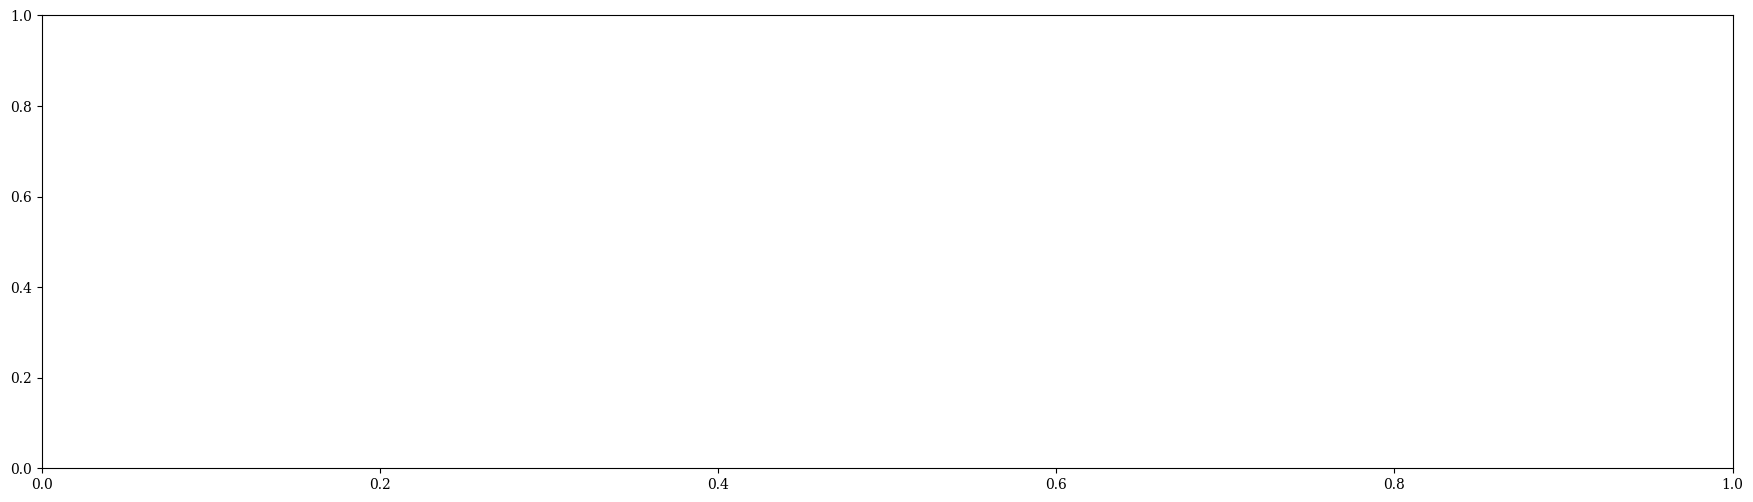

In [139]:
out_sample=test_data

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        best_yt_totest[:,i] = pd.DataFrame(best_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(best_yt_totest,1,axis=0)
    y_pp[0,:] = data[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = data[in_sample.shape[0],:]
    Y__ = best_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = best_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = best_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V2/best_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(f'{dataframe.columns[i]}',fontsize=32)
    plt.plot(best_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'], fontsize=26)
    plt.xlabel('Tempo(h)',fontsize=26)
    plt.ylabel('Valor',fontsize=26)
    k += 1


plt.savefig('results V2/best_model.png')    #plt.show()
plt.close()

In [140]:
ensemble_rules.shape

(91, 5)

In [141]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
ensemble_wd_, ensemble_agg_training = model.reweight_mf(mY_,ensemble_rules,ensemble_prem_terms)

In [143]:
ensemble_yt_totest, ensemble_errors = model.predict(initial_values, 
                                      data=dataset, 
                                      out_sample=test_data, 
                                      agg_training=ensemble_agg_training,
                                      h_prev=h_teste,
                                      n_attempt='ensemble_model',
                                      wd_=ensemble_wd_ ,
                                      ensemble_antecedents=ensemble_antecedents,
                                      ensemble_rules=ensemble_rules,
                                      filepath=filepath,
                                      lim=min_error, 
                                      fig_axis=[4,2],
                                      ndata=data.columns,
                                      show=False,
                                      plot_image = True)

In [144]:
ensemble_errors

array([[ 43.54117857,   7.50214863, 149.1229356 ,   5.93027761,
          1.34506911],
       [ 39.59595598,   6.06254404, 130.11663508,   5.25685281,
          1.208706  ],
       [  0.49047515,   2.41095436,   1.09865119,   0.37663267,
          1.58714842]])

NameError: name 'dataframe' is not defined

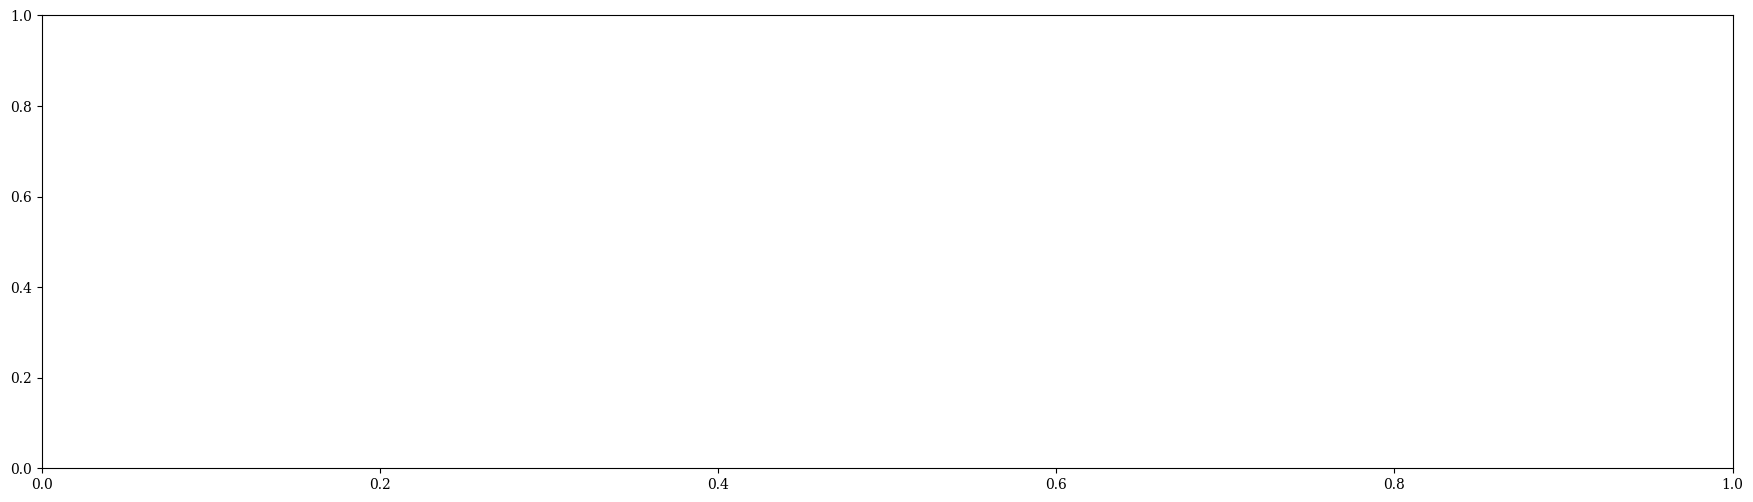

In [145]:

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        ensemble_yt_totest[:,i] = pd.DataFrame(ensemble_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(ensemble_yt_totest,1,axis=0)
    y_pp[0,:] = data[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = data[in_sample.shape[0],:]
    Y__ = ensemble_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = ensemble_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = ensemble_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V2/ensemble_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(f'{dataframe.columns[i]}',fontsize=20)
    plt.plot(ensemble_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'])
    plt.xlabel('Tempo(h)',fontsize=15)
    plt.ylabel('Valor',fontsize=15)
    k += 1


plt.savefig('results V2/ensemble_model.png')    #plt.show()
plt.close()

In [146]:
cnt = 0
list_remove = []

dict_val = {}

for i in range(ensemble_prem_terms.shape[0]):
    except_one = np.copy(ensemble_prem_terms)
    v = except_one[i,:]
    idx = np.argwhere(v > 0.5).ravel()
    v = v[idx]
    rest = np.delete(except_one, i, axis=0)
    rest = rest[:,idx]
    cpare = np.tile(v,(rest.shape[0],1))
    m = np.minimum(rest,cpare) 
    M = np.maximum(rest,cpare) + 10e-15
    res = m/M
    mean = np.mean(res,axis=1)
    #plt.figure()
    #plt.hist(mean)
    
    vv = np.argwhere(mean > 0.6).ravel()

    if vv.shape[0] > 0:    
        vv[vv > i] += 1
        vv2 = np.append(vv,np.array([i]))

        eval_v = ensemble_prem_terms[vv2][:,idx]

        t = np.mean(eval_v,axis=1)

        keep_val = vv2[np.argmax(t)]
        vmax = np.max(t)
        print(f'{keep_val} : {vmax}')
        if keep_val not in list_remove:
            dict_val[keep_val] = 1
            list_remove.append(keep_val)
        else:
            dict_val[keep_val] = dict_val[keep_val] + 1

        cnt += np.argwhere(mean > 0.6).shape[0]


0 : 0.911461929433549
42 : 0.922833685738068
34 : 0.8667820543509068
22 : 0.8667820543509068
4 : 0.8496178285927222
5 : 0.8456076373551947
6 : 0.844121863166016
7 : 0.844121863166016
88 : 0.844121863166016
9 : 0.8587127679043323
0 : 0.9219314679781232
34 : 0.9175072136360088
35 : 0.9128604427690258
22 : 0.9120225624110356
14 : 0.884091715318704
15 : 0.884091715318704
16 : 0.880614466778265
37 : 0.9110187708436678
38 : 0.9114586755828711
19 : 0.8835145894583928
40 : 0.9144043874490875
42 : 0.922833685738068
36 : 0.9023303880517798
23 : 0.9029683186604668
0 : 0.9219314679781232
35 : 0.9128604427690258
34 : 0.8667820543509068
27 : 0.8476391158110474
5 : 0.8456076373551947
7 : 0.844121863166016
30 : 0.849660476922443
47 : 0.858628625339744
32 : 0.8587127679043323
0 : 0.911461929433549
34 : 0.907422392860314
35 : 0.9031796890252425
22 : 0.9023303880517798
37 : 0.9027048408858196
38 : 0.9031084232153639
39 : 0.906406989435922
40 : 0.9029683186604668
23 : 0.9029683186604668
54 : 0.90624970280

In [147]:
filtered_rules = deepcopy(ensemble_rules[list_remove,:])
filtered_prems = deepcopy(ensemble_prem_terms[list_remove,:])
filtered_antecedents = deepcopy(ensemble_antecedents[list_remove,:])

In [148]:
filtered_rules.shape

(36, 5)

In [149]:
model.set_fuzzification(Fuzzyfy, mf_params_, mX_, mY_, mX_lagged_)
filtered_wd_, filtered_agg_training = model.reweight_mf(mY_,filtered_rules,filtered_prems)

In [150]:
filtered_yt_totest, filtered_errors = model.predict(initial_values, 
                                 data=dataset,
                                 out_sample=test_data, 
                                 agg_training=filtered_agg_training,
                                h_prev=h_teste,
                                 n_attempt='filtered_model',
                                 wd_=filtered_wd_,
                                 ensemble_antecedents=filtered_antecedents,
                                 ensemble_rules=filtered_rules, 
                                 filepath=filepath, lim=min_error,
                                 fig_axis=[4,2],
                                 ndata=data.columns,
                                 show=False,
                                 plot_image = True) 

In [151]:
filtered_errors

array([[41.88280969,  2.39342577, 38.24474282,  5.92658832,  0.33481378],
       [36.64192822,  1.99320873, 29.75311476,  5.08282588,  0.27733169],
       [ 0.46455664,  0.70125494,  0.22765186,  0.36414193,  0.3867452 ]])

In [ ]:

for i in range(num_series):
    idx = np.where(np.isnan(yt_totest[:,i]))

    if len(idx) > 0:
        filtered_yt_totest[:,i] = pd.DataFrame(filtered_yt_totest[:,i]).fillna(method='bfill').values.ravel()

if diff_series:
    #Y__ = yt_totest + data[in_sample.shape[0]:data.shape[0]-1,:]
    #Yt__ = out_sample + data[in_sample.shape[0]:data.shape[0]-1,:]
    y_pp = np.roll(filtered_yt_totest,1,axis=0)
    y_pp[0,:] = data[in_sample.shape[0],:]
    y_tt = np.roll(out_sample,1,axis=0)
    y_tt[0,:] = data[in_sample.shape[0],:]
    Y__ = filtered_yt_totest + y_pp
    Yt__ = out_sample + y_tt
    print('diff series')

elif detrend_series:
    Y__ = filtered_yt_totest + trends[in_sample.shape[0]:,:]
    Yt__ = out_sample + trends[in_sample.shape[0]:,:]

else:
    Y__ = filtered_yt_totest
    Yt__ = out_sample
errors = np.zeros(shape=(3,num_series))
rmse = sqrt(mean_squared_error(Yt__[:,0], Y__[:,0]))
mae = mean_absolute_error(Yt__[:,0], Y__[:,0])
MAPE = mape(Yt__[:, 0], Y__[:, 0])
errors[0,0] = rmse
errors[1,0] = mae
errors[2, 0] = MAPE

with open('results V2/filtered_model.txt','w') as f:
    for i in range(num_series):
        rmse = sqrt(mean_squared_error(Y__[:,i], Yt__[:,i]))
        mae = mean_absolute_error(Y__[:,i], Yt__[:,i])
        MAPE = mape(Yt__[:, i], Y__[:, i])
        #rrse_error = rrse(Y__[:,i], Yt__[:,i])

        #print('Outsample RRSE for serie {} is {} \n'.format(i+1,rrse_error), file=f)
        print('Outsample RMSE for serie {} is {} \n'.format(i+1,rmse), file=f)
        print('Outsample MAE for serie {} is {} \n'.format(i+1,mae), file=f)
        #print('Outsample SMAPE for serie {} is {} \n'.format(i+1,smape(Yt__[:,i],Y__[:,i])),file=f)
        print('Outsample MAPE for serie {} is {} \n'.format(i + 1, 100*MAPE), file=f)
        errors[0,i] = rmse
        errors[1, i] = mae
        errors[2, i] = MAPE
        #errors[1,i] = rrse_error

plt.figure(figsize=(16*3,10*2))
k = 1

fig_axis=[3,2]

for i in range(num_series):
    plt.subplot(fig_axis[0],fig_axis[1],k)
    plt.title(f'{data.columns[i]}',fontsize=20)
    plt.plot(filtered_yt_totest[:,i],color='orange')
    plt.plot(out_sample[:,i],color='blue')
    plt.legend(['Previsto','Real'])
    plt.xlabel('Tempo(h)',fontsize=15)
    plt.ylabel('Valor',fontsize=15)
    k += 1


plt.savefig('results V2/filtered_model.png')    #plt.show()
plt.close()

In [ ]:
# import seaborn as sns 

# frame = pd.concat([
#         pd.DataFrame({'tempo(h)': range(len(out_sample)), 'NO2(GT)': test_data[:,0], 'type': 'real'}),
#         pd.DataFrame({'tempo(h)': range(len(out_sample)), 'NO2(GT)': filtered_yt_totest[:,0], 'type': 'previsto'})
#     ])
    
# #     frame['temp'] = [(x * (train_max['NO2(GT)'] - train_min['NO2(GT)'])) + train_min['NO2(GT)'] for x in frame['NO2(GT)']]
    
# sns.lineplot(x='tempo(h)', y='NO2(GT)', data=frame, hue='type')
        
# plt.tight_layout()
# plt.savefig('results/final_filtered.png')
# plt.show()